# Semi Synthetic Experiment 
Semi-synthetic dataset experiment

In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

# Import Dataset into Notebook

In [2]:
# dataset = '/Users/patroklos/Desktop/research/'
# df = pd.read_excel(dataset)
# df.head()

bunch = load_boston()
data = np.concatenate([bunch['data'], np.expand_dims(bunch['target'], 1)], axis=1)
df = pd.DataFrame(data, columns=bunch['feature_names'].tolist() + ['MEDV'])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


The first thing that we want to do is check if there are any columns with NaN values in the dataframe.

In [3]:
nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


We see that there are two columsn with NaN values in them. We will fill the values of these columns with the mean of the rest of the data for the feature.

In [4]:
if len(columns_with_nan) > 0: 
    df['Ozone'].replace(np.nan, df['Ozone'].dropna().mean(), inplace=True)
    df['Solar.R'].replace(np.nan, df['Solar.R'].dropna().mean(), inplace=True)
# drop Unnamed: 0 column if in dataframe
if 'Unnamed: 0' in df.columns:
    df.drop(columns='Unnamed: 0', inplace=True)

# Data Exploration

In [5]:
columns = ['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
X, y = df[['ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']].to_numpy(), df['MEDV'].to_numpy().reshape(-1, 1)
# X, y = df[['X2 house age', 'X4 number of convenience stores', 'X3 distance to the nearest MRT station', 'X6 longitude']].to_numpy(), df['Y house price of unit area'][...,None]

X, y = Tensor(X), Tensor(y)

(array([ 2.,  1.,  1.,  0.,  5.,  2.,  1.,  6.,  3.,  0.,  3.,  3.,  5.,
         3.,  4.,  6.,  3.,  5., 14.,  9.,  9.,  6., 11.,  8.,  6.,  6.,
         8., 10.,  9.,  9., 15., 13., 20., 16., 19., 10., 14., 19., 13.,
        15., 21., 11., 14., 12., 14.,  1.,  0.,  4.,  5.,  2.,  6.,  3.,
         7.,  4.,  3.,  6.,  2.,  3.,  4.,  3.,  4.,  2.,  7.,  2.,  1.,
         1.,  5.,  3.,  1.,  4.,  1.,  3.,  1.,  1.,  1.,  0.,  0.,  1.,
         0.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,  1.,  1.,  0.,
         1.,  1.,  0.,  0.,  0.,  2.,  1.,  0., 16.]),
 array([ 5.  ,  5.45,  5.9 ,  6.35,  6.8 ,  7.25,  7.7 ,  8.15,  8.6 ,
         9.05,  9.5 ,  9.95, 10.4 , 10.85, 11.3 , 11.75, 12.2 , 12.65,
        13.1 , 13.55, 14.  , 14.45, 14.9 , 15.35, 15.8 , 16.25, 16.7 ,
        17.15, 17.6 , 18.05, 18.5 , 18.95, 19.4 , 19.85, 20.3 , 20.75,
        21.2 , 21.65, 22.1 , 22.55, 23.  , 23.45, 23.9 , 24.35, 24.8 ,
        25.25, 25.7 , 26.15, 26.6 , 27.05, 27.5 , 27.95, 28.4 , 28.85,
        

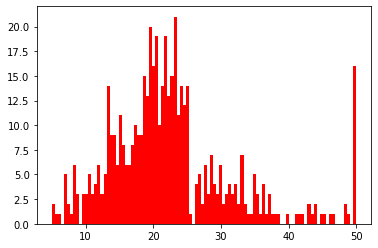

In [6]:
plt.hist(y.T, bins=100, color='red')

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [7]:
df = df[columns]

In [8]:
corr_matrix = df.corr()
corr_matrix

,ZN,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
ZN,1.000000,-0.042697,-0.516604,0.311991,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
CHAS,-0.042697,1.000000,0.091203,0.091251,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,-0.516604,0.091203,1.000000,-0.302188,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,0.311991,0.091251,-0.302188,1.000000,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
DIS,0.664408,-0.099176,-0.769230,0.205246,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,-0.311948,-0.007368,0.611441,-0.209847,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,-0.314563,-0.035587,0.668023,-0.292048,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536
PTRATIO,-0.391679,-0.121515,0.188933,-0.355501,-0.232471,0.464741,0.460853,1.000000,-0.177383,0.374044,-0.507787
B,0.175520,0.048788,-0.380051,0.128069,0.291512,-0.444413,-0.441808,-0.177383,1.000000,-0.366087,0.333461
LSTAT,-0.412995,-0.053929,0.590879,-0.613808,-0.496996,0.488676,0.543993,0.374044,-0.366087,1.000000,-0.737663


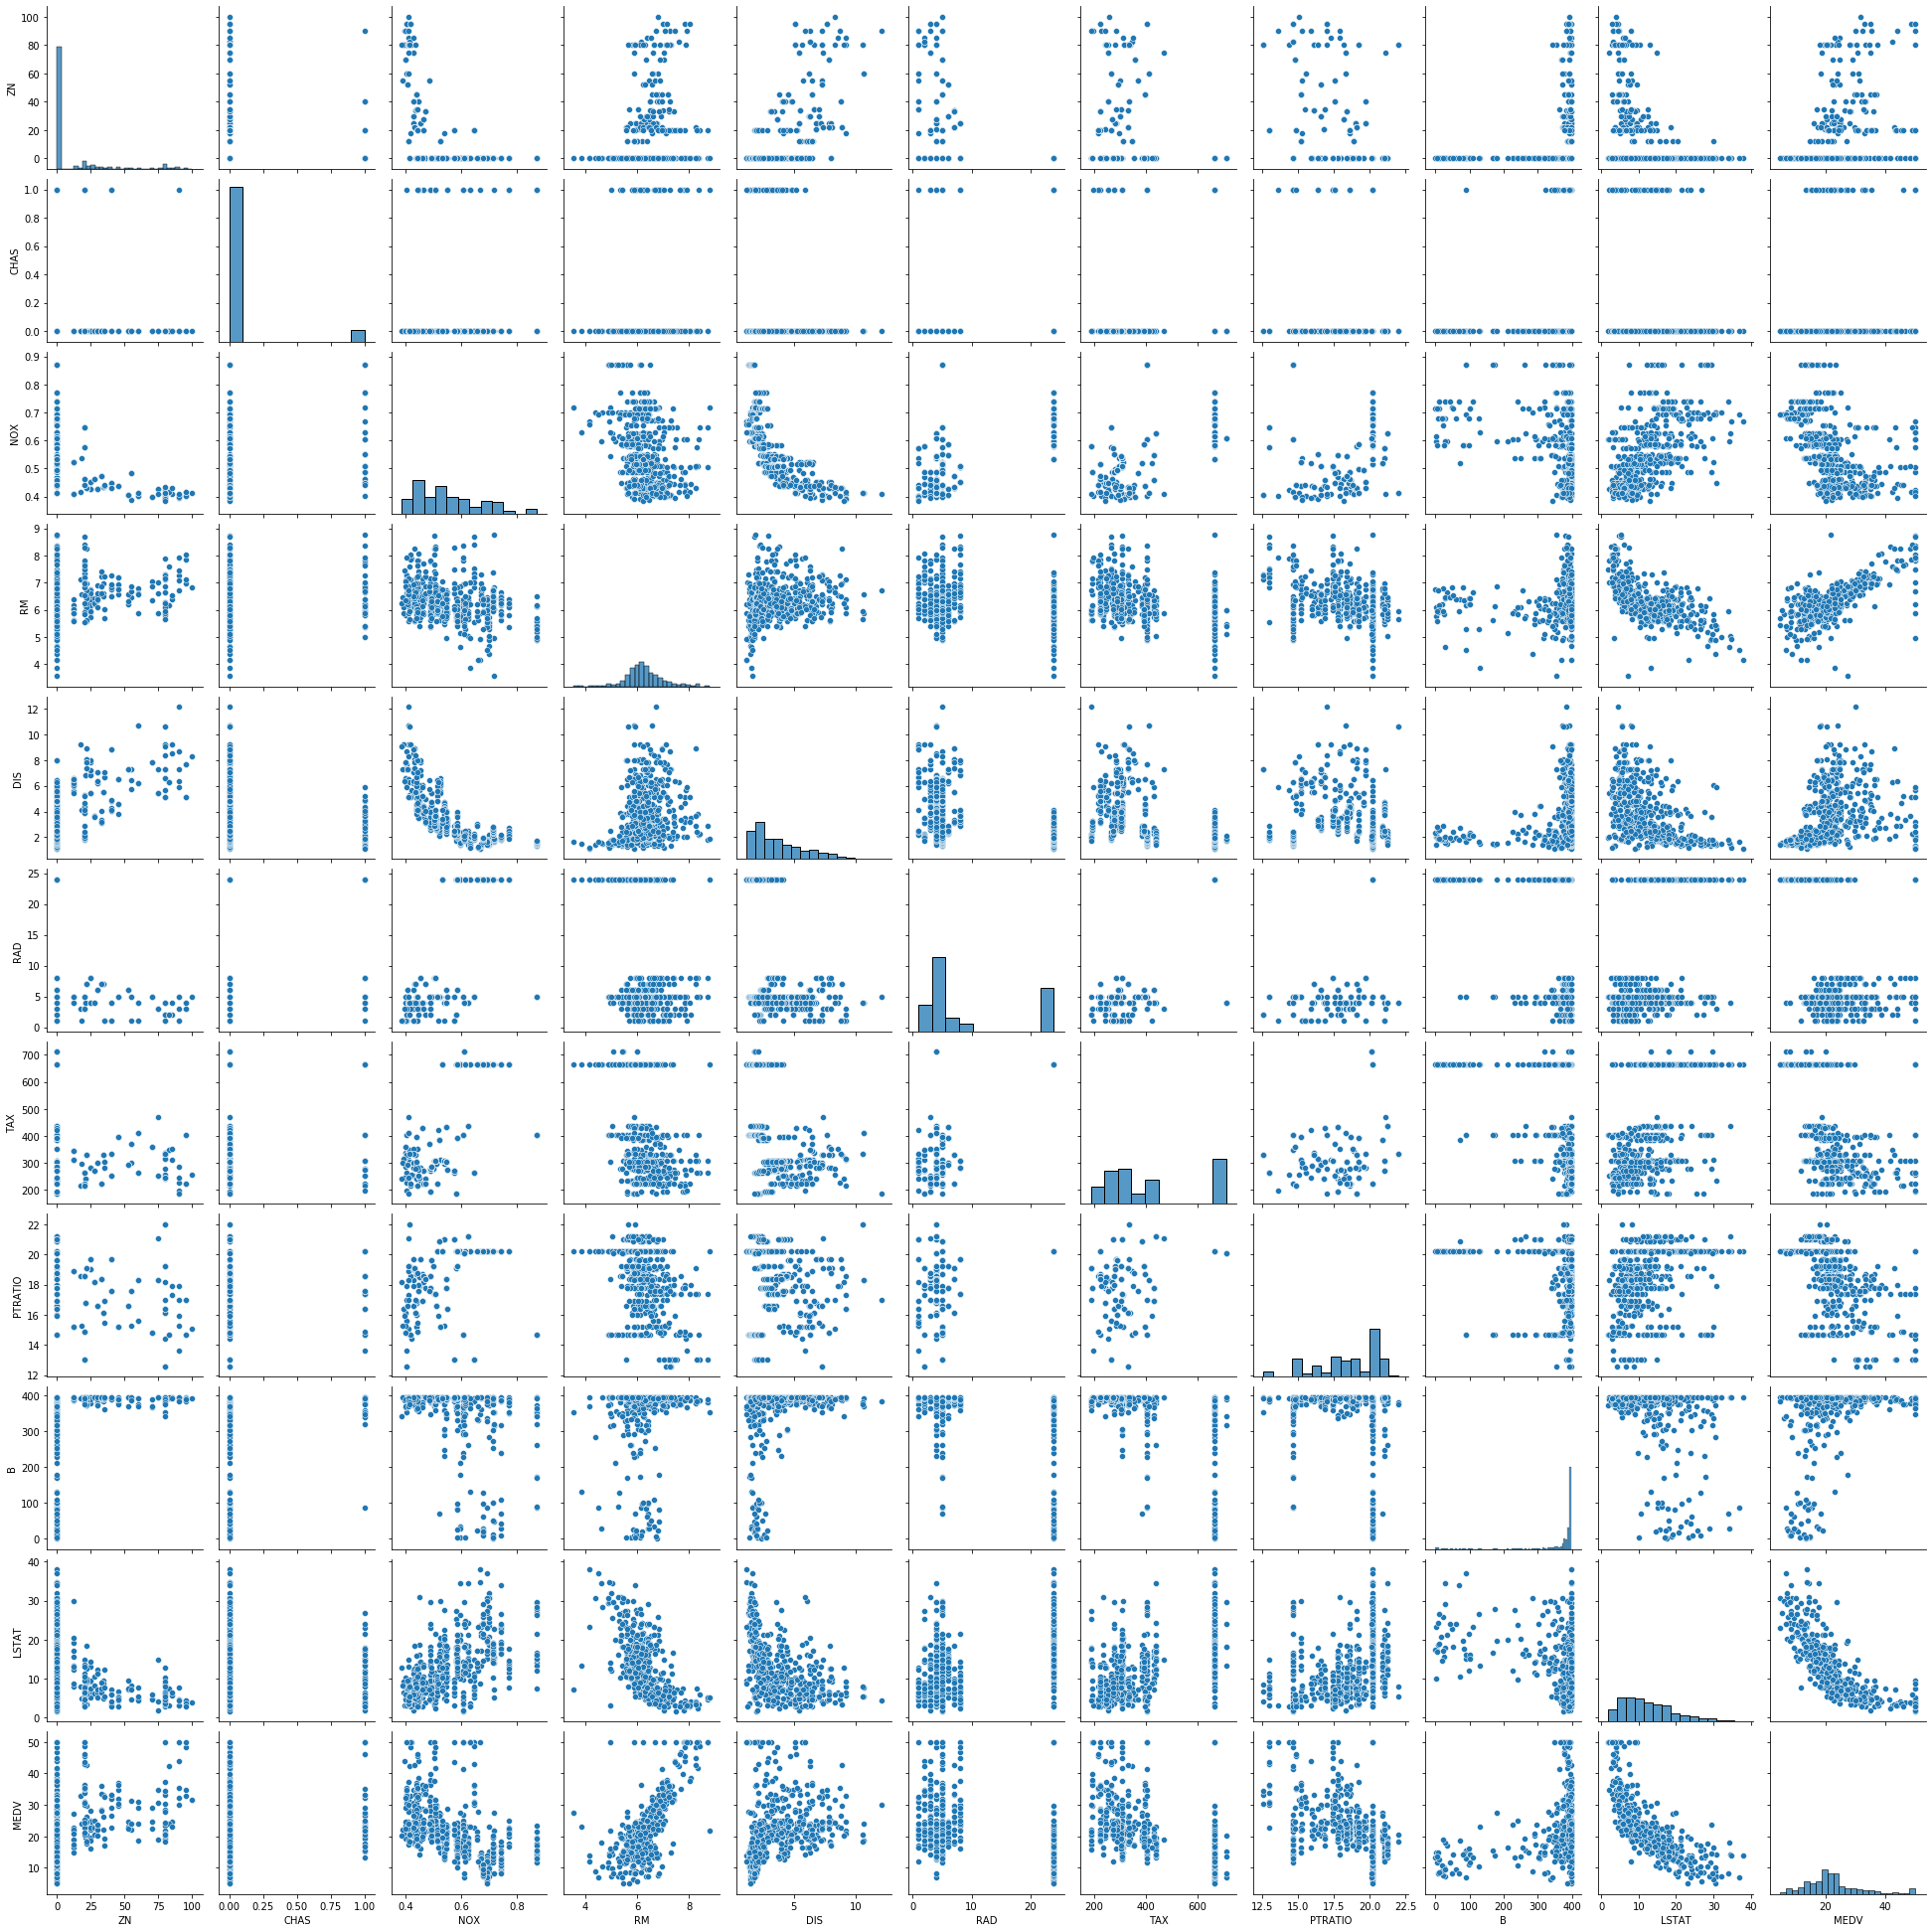

In [9]:
sns.pairplot(df)

First, let's take see if there is a linear relationship between solar.R and Ozone.

In [9]:
data = ch.linspace(0, 1500, 100).reshape(100, 1)

gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("r^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

r^2:  0.7348380172045117
ground-truth variance:  22.429183959960938


# Now we standardize our empirical data and generate new ols estimates

In [10]:
random = ch.randn(X.shape[1], 2)
x_transform = X@random
w_transform = Tensor(gt_ols.coef_)@random

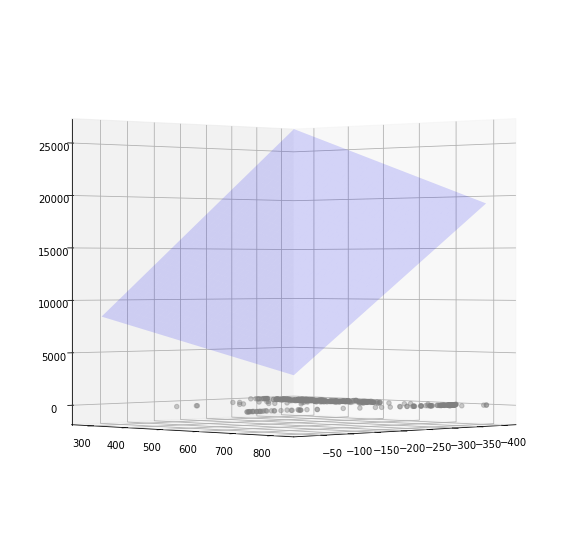

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

# X_ = np.arange(-50, 50, 0.25)
# Y = np.arange(-50, 50, 0.25)

x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 5.0)
Y = np.arange(x_min[1], x_max[1], 5.0)
X_, Y = np.meshgrid(X_, Y) 

# pred = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     pred = ch.cat([pred, input_@w_transform.T + ols.intercept_], 1)
# ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')


# emp = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     emp = ch.cat([emp, Tensor(ols.predict(input_))], 1)
# ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='grey', label='S', alpha=.4)
# ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='grey', label='S', alpha=.4)
ax.view_init(0, 45)

In [12]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

x = StandardScaler().fit_transform(X.T)

pca = PCA(n_components = 2)
pca.fit(x)


PCA(n_components=2)

In [13]:
principal_components = pca.components_.T

In [14]:
pca_ols = LinearRegression()
pca_ols.fit(principal_components, y)

LinearRegression()

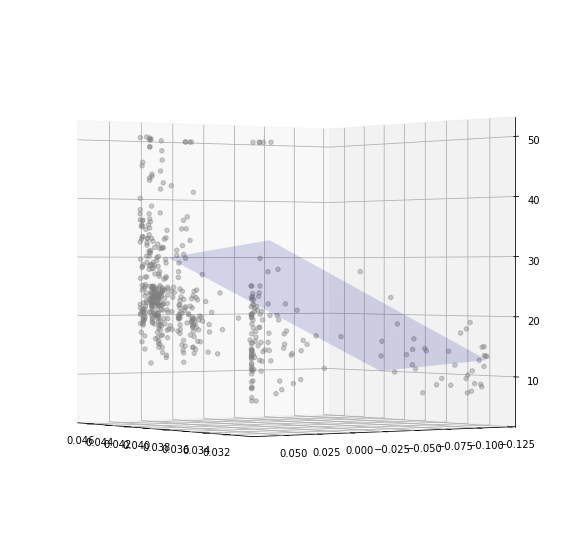

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = Tensor(principal_components.max(0)), Tensor(principal_components.min(0))
X_ = np.arange(x_min[0], x_max[0], 0.01)
Y = np.arange(x_min[1], x_max[1], 0.01)
X_, Y = np.meshgrid(X_, Y) 

# pred = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     pred = ch.cat([pred, input_@w_transform.T + ols.intercept_], 1)
# ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, Tensor(pca_ols.predict(input_))], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')


# emp = Tensor([])
# for i in range(X_.shape[0]): 
#     input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
#     emp = ch.cat([emp, Tensor(ols.predict(input_))], 1)
# ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')

ax.scatter3D(principal_components[:,0], principal_components[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 145)

# Truncate Dataset

In [141]:
phi = oracle.Left(20)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

alpha:  0.575098814229249


In [142]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))

r^2:  0.4670807850836223
empirical variance:  22.095067977905273


In [143]:
x_trunc_transform = x_transform[indices]
w = Tensor(trunc_ols.coef_)@random

# Truncate Regression


# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

In [144]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

LinearRegression()

In [145]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

LinearRegression()

In [146]:
w_trunc_transform = Tensor(trunc_ols.coef_)@random

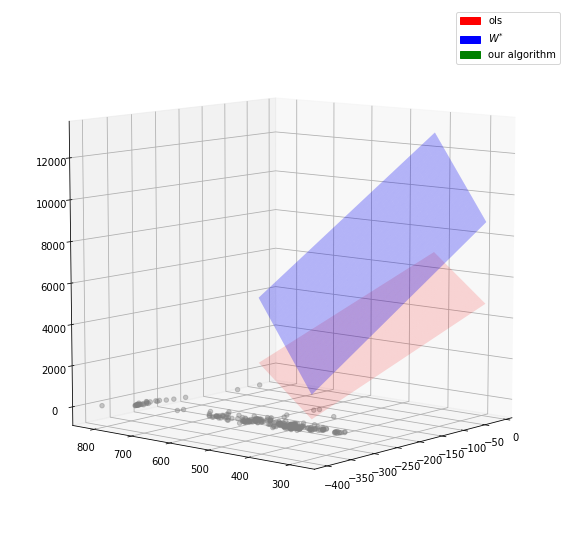

In [147]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0]/2, 1.0)
Y = np.arange(x_min[1], x_max[1]/2, 1.0)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@w_transform.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='blue')

ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(9.0, 220)

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [148]:
reg = LinearRegression().fit(x_trunc_norm, y_trunc_scaled)

In [149]:
reg.coef_, reg.intercept_

(array([[   18.88254 ,   787.4221  , -4972.1377  ,  2633.556   ,
          -646.74243 ,   214.78758 ,    -5.972389,  -320.45624 ,
           -11.254149,  -300.3299  ]], dtype=float32),
 array([0.36083272], dtype=float32))

In [150]:
gt_var, emp_var

(tensor([22.4292]), tensor([22.0951]))

In [151]:
scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=1e-1, unknown=False, bs=10, n=1, tol=1e-2, steps=2500, val=int(.1*y_trunc.size(0)))
trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

empirical weight:  Parameter containing:
tensor([[   18.8825,   787.4221, -4972.1377,  2633.5559,  -646.7424,   214.7876,
            -5.9724,  -320.4562,   -11.2541,  -300.3299]], requires_grad=True)
empirical bias:  Parameter containing:
tensor([0.3608], requires_grad=True)
weight bounds:  Bounds(lower=tensor([-4.9404e+00,  1.2093e+03, -5.3137e+03,  2.3596e+03, -7.1175e+02,
         1.5237e+02, -2.8686e+01, -4.0427e+02, -3.9637e+01, -3.5918e+02]), upper=tensor([   43.0014,  1257.2842, -5265.7417,  2407.5557,  -663.8094,   200.3102,
           19.2559,  -356.3237,     8.3044,  -311.2369]))
bias bounds:  Bounds(lower=tensor([-21.4898]), upper=tensor([26.4519]))
weight before:  Parameter containing:
tensor([[   18.8825,   787.4221, -4972.1377,  2633.5559,  -646.7424,   214.7876,
            -5.9724,  -320.4562,   -11.2541,  -300.3299]], requires_grad=True)
weight grad:  tensor([[0.0039, 0.0000, 0.0001, 0.0014, 0.0011, 0.0005, 0.0702, 0.0044, 0.0898,
         0.0018]])
bias before:  Para

Linear(in_features=10, out_features=1, bias=True)

In [154]:
known_w, known_w0 = (trunc_reg.weight * ch.sqrt(gt_var)) / beta, trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

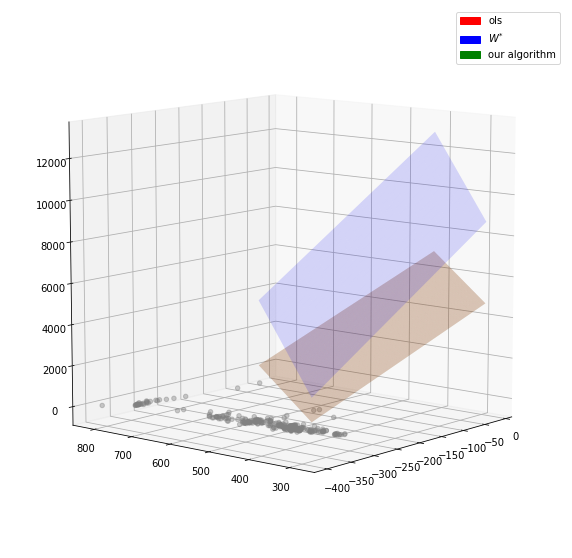

In [155]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0]/2, 1.0)
Y = np.arange(x_min[1], x_max[1]/2, 1.0)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    known_w_transform = known_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(10.0, 220)

In [156]:
emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=1e-2, step_lr_gamma=1.0, bs=10, n=100, tol=1e-1, steps=2000, val=int(.1*y_trunc.size(0)))
trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

empirical weight:  Parameter containing:
tensor([[   19.0248,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4057,
            -6.0174,  -322.8699,   -11.3389,  -302.5919]], requires_grad=True)
empirical bias:  Parameter containing:
tensor([0.3635], requires_grad=True)
weight bounds:  Bounds(lower=tensor([  -16.0021,   869.9271, -4606.3906,  2592.8062,  -665.3607,   176.1867,
          -39.4233,  -384.2904,   -44.9140,  -345.3293]), upper=tensor([   51.9397,   937.8689, -4538.4492,  2660.7480,  -597.4189,   244.1284,
           28.5184,  -316.3486,    23.0278,  -277.3876]))
bias bounds:  Bounds(lower=tensor([-33.5406]), upper=tensor([34.4012]))
weight before:  Parameter containing:
tensor([[   19.0248,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4057,
            -6.0174,  -322.8699,   -11.3389,  -302.5919]], requires_grad=True)
weight grad:  tensor([[-4.8053e-03,  3.6434e-05,  7.9227e-05,  7.6133e-04,  3.4434e-04,
          1.7405e-03,  6.2220e-02,  2.7323e-03,  5.212

lambda grad:  tensor([[-0.1938]])
weight after:  Parameter containing:
tensor([[   19.0242,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4055,
            -6.0293,  -322.8706,   -11.3529,  -302.5923]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.2810], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.8932]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0242,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4055,
            -6.0293,  -322.8706,   -11.3529,  -302.5923]], requires_grad=True)
weight grad:  tensor([[ 1.6920e-03, -1.1292e-05,  9.0567e-05,  1.1863e-03,  9.1221e-04,
          1.5236e-03,  6.2183e-02,  3.8794e-03,  7.9170e-02,  2.6158e-03]])
bias before:  Parameter containing:
tensor([0.2810], requires_grad=True)
bias grad:  tensor([0.4510])
lambda before:  Parameter containing:
tensor([[0.8932]], requires_grad=True)
lambda grad:  tensor([[0.6466]])
weight after:  Parameter containing:
tensor([[ 

weight before:  Parameter containing:
tensor([[   19.0238,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4055,
            -6.0363,  -322.8710,   -11.3631,  -302.5926]], requires_grad=True)
weight grad:  tensor([[4.1752e-03, 4.9228e-05, 1.2296e-04, 1.4939e-03, 1.0941e-03, 3.4180e-03,
         1.1587e-01, 4.5466e-03, 8.9470e-02, 2.3414e-03]])
bias before:  Parameter containing:
tensor([0.2220], requires_grad=True)
bias grad:  tensor([0.5233])
lambda before:  Parameter containing:
tensor([[0.7054]], requires_grad=True)
lambda grad:  tensor([[-0.1208]])
weight after:  Parameter containing:
tensor([[   19.0238,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4054,
            -6.0375,  -322.8710,   -11.3640,  -302.5926]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.2168], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7175]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0238,   793.3527, -5009.5923,  2653.3

lambda grad:  tensor([[0.0388]])
weight after:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4050,
            -6.0569,  -322.8720,   -11.3840,  -302.5932]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0992], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7910]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4050,
            -6.0569,  -322.8720,   -11.3840,  -302.5932]], requires_grad=True)
weight grad:  tensor([[-2.7634e-03, -2.8261e-05, -5.8407e-06, -2.5862e-04, -2.0069e-04,
         -7.3139e-05, -3.7210e-03,  6.3821e-06, -4.2323e-03,  5.3946e-04]])
bias before:  Parameter containing:
tensor([0.0992], requires_grad=True)
bias grad:  tensor([-0.0240])
lambda before:  Parameter containing:
tensor([[0.7910]], requires_grad=True)
lambda grad:  tensor([[0.6181]])
weight after:  Parameter containing:
tensor([[ 

weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4049,
            -6.0655,  -322.8726,   -11.3966,  -302.5936]], requires_grad=True)
weight grad:  tensor([[-1.5117e-03,  3.2316e-05, -3.5931e-05, -5.4931e-04, -4.2613e-04,
         -5.9589e-04, -3.3357e-02, -1.2360e-03, -2.6932e-02, -1.7526e-04]])
bias before:  Parameter containing:
tensor([0.0260], requires_grad=True)
bias grad:  tensor([-0.1582])
lambda before:  Parameter containing:
tensor([[0.7077]], requires_grad=True)
lambda grad:  tensor([[0.0119]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4049,
            -6.0652,  -322.8726,   -11.3963,  -302.5936]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0276], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7065]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.592

weight grad:  tensor([[5.7989e-03, 0.0000e+00, 5.4631e-05, 6.1190e-04, 7.9453e-04, 8.7578e-04,
         4.7990e-02, 2.6323e-03, 4.3587e-02, 6.3844e-04]])
bias before:  Parameter containing:
tensor([-0.0512], requires_grad=True)
bias grad:  tensor([0.2543])
lambda before:  Parameter containing:
tensor([[0.7038]], requires_grad=True)
lambda grad:  tensor([[0.3770]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0785,  -322.8733,   -11.4101,  -302.5940]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0537], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6661]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0785,  -322.8733,   -11.4101,  -302.5940]], requires_grad=True)
weight grad:  tensor([[0.0003, 0.0003, 0.0003, 0.0031, 0.0007, 0.0075, 0.2244, 0.0072, 0.

weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0843,  -322.8736,   -11.4165,  -302.5941]], requires_grad=True)
weight grad:  tensor([[2.7768e-04, 4.1471e-05, 1.1662e-04, 1.2224e-03, 4.7588e-04, 1.7434e-03,
         7.6442e-02, 3.1300e-03, 6.8433e-02, 1.7973e-03]])
bias before:  Parameter containing:
tensor([-0.0914], requires_grad=True)
bias grad:  tensor([0.4190])
lambda before:  Parameter containing:
tensor([[0.6250]], requires_grad=True)
lambda grad:  tensor([[-0.3038]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0850,  -322.8737,   -11.4172,  -302.5942]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0956], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6554]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653

weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0707,  -322.8727,   -11.3980,  -302.5936]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0160], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7716]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0707,  -322.8727,   -11.3980,  -302.5936]], requires_grad=True)
weight grad:  tensor([[2.0556e-03, 1.6288e-05, 8.4653e-05, 8.0006e-04, 4.1783e-04, 2.7154e-03,
         7.5107e-02, 2.6035e-03, 5.4683e-02, 1.5673e-03]])
bias before:  Parameter containing:
tensor([0.0160], requires_grad=True)
bias grad:  tensor([0.3105])
lambda before:  Parameter containing:
tensor([[0.7716]], requires_grad=True)
lambda grad:  tensor([[0.1090]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.394

weight grad:  tensor([[ 4.3417e-03, -5.1411e-05, -3.0005e-05, -2.5540e-04,  1.5445e-04,
         -1.6199e-03, -4.2139e-02, -4.7122e-04, -9.3366e-03,  2.8664e-05]])
bias before:  Parameter containing:
tensor([-0.0396], requires_grad=True)
bias grad:  tensor([-0.0716])
lambda before:  Parameter containing:
tensor([[0.5568]], requires_grad=True)
lambda grad:  tensor([[0.6224]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0777,  -322.8732,   -11.4074,  -302.5938]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0389], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.4945]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0777,  -322.8732,   -11.4074,  -302.5938]], requires_grad=True)
weight grad:  tensor([[ 4.0460e-04, -1.8515e-04, -1.0056e-04, -8.4623e-04, -7.

weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0857,  -322.8735,   -11.4163,  -302.5941]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0913], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7013]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0857,  -322.8735,   -11.4163,  -302.5941]], requires_grad=True)
weight grad:  tensor([[ 1.5241e-03, -7.9375e-05, -4.0665e-05, -4.7335e-04,  1.3197e-04,
         -1.5355e-03, -4.0534e-02, -1.0242e-03, -2.1798e-02,  1.2565e-05]])
bias before:  Parameter containing:
tensor([-0.0913], requires_grad=True)
bias grad:  tensor([-0.1228])
lambda before:  Parameter containing:
tensor([[0.7013]], requires_grad=True)
lambda grad:  tensor([[0.6006]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.59

lambda after:  Parameter containing:
tensor([[0.7236]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0681,  -322.8726,   -11.3972,  -302.5936]], requires_grad=True)
weight grad:  tensor([[2.6688e-03, 0.0000e+00, 5.3479e-05, 5.7059e-04, 4.9194e-04, 8.8440e-04,
         4.4483e-02, 2.2212e-03, 4.0573e-02, 7.5446e-04]])
bias before:  Parameter containing:
tensor([0.0216], requires_grad=True)
bias grad:  tensor([0.2316])
lambda before:  Parameter containing:
tensor([[0.7236]], requires_grad=True)
lambda grad:  tensor([[0.2970]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0685,  -322.8727,   -11.3976,  -302.5936]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0192], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6939]], requires_grad=True)
weight before: 

lambda after:  Parameter containing:
tensor([[0.6970]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0226,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0798,  -322.8732,   -11.4091,  -302.5939]], requires_grad=True)
weight grad:  tensor([[5.2987e-03, 2.4599e-05, 1.1254e-04, 1.4076e-03, 1.1067e-03, 1.5343e-03,
         8.0970e-02, 4.0600e-03, 8.7201e-02, 2.9076e-03]])
bias before:  Parameter containing:
tensor([-0.0488], requires_grad=True)
bias grad:  tensor([0.5157])
lambda before:  Parameter containing:
tensor([[0.6970]], requires_grad=True)
lambda grad:  tensor([[0.0051]])
weight after:  Parameter containing:
tensor([[   19.0226,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0806,  -322.8732,   -11.4099,  -302.5940]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0539], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6965]], requires_grad=True)
weight before

lambda after:  Parameter containing:
tensor([[0.5487]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0860,  -322.8736,   -11.4172,  -302.5941]], requires_grad=True)
weight grad:  tensor([[ 3.4108e-03, -6.1327e-05, -4.1578e-05, -4.3058e-04,  5.0960e-05,
         -1.6456e-03, -4.9345e-02, -8.5749e-04, -1.8572e-02,  1.3726e-04]])
bias before:  Parameter containing:
tensor([-0.0969], requires_grad=True)
bias grad:  tensor([-0.1252])
lambda before:  Parameter containing:
tensor([[0.5487]], requires_grad=True)
lambda grad:  tensor([[0.7938]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0855,  -322.8736,   -11.4170,  -302.5941]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0957], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.4694]], requires_grad=True)
we

weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0904,  -322.8738,   -11.4236,  -302.5943]], requires_grad=True)
weight grad:  tensor([[-4.3581e-03,  2.0130e-05, -8.0646e-05, -1.2725e-03, -8.8484e-04,
         -1.0510e-03, -6.1520e-02, -2.9871e-03, -6.5845e-02, -6.8766e-04]])
bias before:  Parameter containing:
tensor([-0.1344], requires_grad=True)
bias grad:  tensor([-0.3840])
lambda before:  Parameter containing:
tensor([[0.7505]], requires_grad=True)
lambda grad:  tensor([[0.4005]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0898,  -322.8738,   -11.4229,  -302.5943]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1306], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7104]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5

weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0957,  -322.8741,   -11.4289,  -302.5946]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1664], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6306]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0957,  -322.8741,   -11.4289,  -302.5946]], requires_grad=True)
weight grad:  tensor([[-9.7973e-04,  0.0000e+00,  5.0773e-05,  5.7478e-04,  3.1307e-04,
          5.0180e-04,  2.6538e-02,  1.8498e-03,  3.6196e-02,  9.8295e-04]])
bias before:  Parameter containing:
tensor([-0.1664], requires_grad=True)
bias grad:  tensor([0.2124])
lambda before:  Parameter containing:
tensor([[0.6306]], requires_grad=True)
lambda grad:  tensor([[-0.0426]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.59

lambda grad:  tensor([[-0.1626]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1056,  -322.8745,   -11.4376,  -302.5949]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2182], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7768]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1056,  -322.8745,   -11.4376,  -302.5949]], requires_grad=True)
weight grad:  tensor([[-1.9792e-03, -4.1867e-05,  1.2082e-05,  7.5210e-05, -6.3853e-05,
          4.3451e-04,  1.3290e-02,  9.2746e-04,  1.3426e-02,  1.2100e-03]])
bias before:  Parameter containing:
tensor([-0.2182], requires_grad=True)
bias grad:  tensor([0.0725])
lambda before:  Parameter containing:
tensor([[0.7768]], requires_grad=True)
lambda grad:  tensor([[0.6581]])
weight after:  Parameter containing:
tensor([

weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0713,  -322.8727,   -11.3989,  -302.5936]], requires_grad=True)
weight grad:  tensor([[ 2.3431e-03,  9.7461e-06,  1.8706e-06,  5.0697e-04,  8.3415e-04,
         -3.0271e-03, -4.8666e-02,  4.8688e-04,  2.3717e-02, -9.7712e-06]])
bias before:  Parameter containing:
tensor([0.0111], requires_grad=True)
bias grad:  tensor([0.1237])
lambda before:  Parameter containing:
tensor([[0.6021]], requires_grad=True)
lambda grad:  tensor([[0.2318]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0708,  -322.8727,   -11.3992,  -302.5936]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0098], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5790]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923

weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0792,  -322.8732,   -11.4095,  -302.5939]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0509], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7364]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0792,  -322.8732,   -11.4095,  -302.5939]], requires_grad=True)
weight grad:  tensor([[3.1274e-05, 0.0000e+00, 1.8930e-05, 1.0057e-04, 1.1967e-05, 4.0112e-04,
         1.8491e-02, 6.5727e-04, 1.1613e-02, 6.1675e-04]])
bias before:  Parameter containing:
tensor([-0.0509], requires_grad=True)
bias grad:  tensor([0.0661])
lambda before:  Parameter containing:
tensor([[0.7364]], requires_grad=True)
lambda grad:  tensor([[0.2774]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3

bias grad:  tensor([0.2796])
lambda before:  Parameter containing:
tensor([[0.6151]], requires_grad=True)
lambda grad:  tensor([[-0.1858]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0870,  -322.8736,   -11.4180,  -302.5941]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1010], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6337]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0870,  -322.8736,   -11.4180,  -302.5941]], requires_grad=True)
weight grad:  tensor([[2.7428e-04, 2.7889e-05, 1.3537e-04, 1.4078e-03, 5.9556e-04, 1.9998e-03,
         8.9092e-02, 3.7864e-03, 7.9047e-02, 2.1592e-03]])
bias before:  Parameter containing:
tensor([-0.1010], requires_grad=True)
bias grad:  tensor([0.4941])
lambda before:  Parameter containing:
tensor([[0.6337]], re

weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0964,  -322.8740,   -11.4270,  -302.5944]], requires_grad=True)
weight grad:  tensor([[-3.8882e-03, -1.9933e-05, -4.1705e-05, -7.2014e-04, -4.4416e-04,
         -3.4825e-04, -3.0738e-02, -1.1614e-03, -3.0630e-02, -3.3013e-05]])
bias before:  Parameter containing:
tensor([-0.1546], requires_grad=True)
bias grad:  tensor([-0.1795])
lambda before:  Parameter containing:
tensor([[0.7071]], requires_grad=True)
lambda grad:  tensor([[0.5738]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0961,  -322.8740,   -11.4267,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1528], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6497]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5

lambda before:  Parameter containing:
tensor([[0.3828]], requires_grad=True)
lambda grad:  tensor([[-3.3882]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0986,  -322.8742,   -11.4320,  -302.5947]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1836], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7216]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0986,  -322.8742,   -11.4320,  -302.5947]], requires_grad=True)
weight grad:  tensor([[-4.5781e-03,  2.4618e-05, -8.2536e-05, -1.2955e-03, -9.1150e-04,
         -1.0387e-03, -5.8743e-02, -3.0751e-03, -6.7731e-02, -6.6419e-04]])
bias before:  Parameter containing:
tensor([-0.1836], requires_grad=True)
bias grad:  tensor([-0.3931])
lambda before:  Parameter containing:
tensor([[0.7216]], requires_grad=True)


lambda grad:  tensor([[0.0068]])
weight after:  Parameter containing:
tensor([[   19.0235,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1019,  -322.8745,   -11.4353,  -302.5948]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2036], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6271]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0235,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1019,  -322.8745,   -11.4353,  -302.5948]], requires_grad=True)
weight grad:  tensor([[-5.6308e-04,  4.1681e-06, -6.6649e-06, -2.2253e-04, -3.2072e-05,
          1.2970e-03,  2.0430e-02, -2.8931e-05, -1.0166e-02,  3.2748e-04]])
bias before:  Parameter containing:
tensor([-0.2036], requires_grad=True)
bias grad:  tensor([-0.0535])
lambda before:  Parameter containing:
tensor([[0.6271]], requires_grad=True)
lambda grad:  tensor([[0.3405]])
weight after:  Parameter containing:
tensor([

weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0710,  -322.8727,   -11.4006,  -302.5937]], requires_grad=True)
weight grad:  tensor([[4.9309e-04, 4.8777e-05, 8.7354e-05, 1.1041e-03, 6.4524e-04, 1.0139e-03,
         5.4451e-02, 2.9009e-03, 6.3512e-02, 1.7436e-03]])
bias before:  Parameter containing:
tensor([0.0016], requires_grad=True)
bias grad:  tensor([0.3821])
lambda before:  Parameter containing:
tensor([[0.8213]], requires_grad=True)
lambda grad:  tensor([[-0.1291]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0715,  -322.8727,   -11.4012,  -302.5937]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0022], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.8342]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.

bias before:  Parameter containing:
tensor([-0.0551], requires_grad=True)
bias grad:  tensor([0.0611])
lambda before:  Parameter containing:
tensor([[0.5479]], requires_grad=True)
lambda grad:  tensor([[0.0684]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0788,  -322.8733,   -11.4103,  -302.5940]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0557], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5410]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0788,  -322.8733,   -11.4103,  -302.5940]], requires_grad=True)
weight grad:  tensor([[ 4.0546e-03, -6.1655e-05, -2.6518e-05, -2.0205e-04,  1.2528e-04,
         -1.6853e-03, -4.2645e-02, -3.2912e-04, -6.6636e-03,  1.7183e-04]])
bias before:  Parameter containing:
tensor([-0.0557], requires_grad=True)
bias 

weight grad:  tensor([[ 8.6797e-04, -7.7153e-05, -4.9611e-05, -5.7537e-04,  2.7734e-05,
         -1.8659e-03, -4.8375e-02, -1.3886e-03, -2.8740e-02, -1.8956e-04]])
bias before:  Parameter containing:
tensor([-0.1111], requires_grad=True)
bias grad:  tensor([-0.1641])
lambda before:  Parameter containing:
tensor([[0.7042]], requires_grad=True)
lambda grad:  tensor([[0.5707]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0861,  -322.8737,   -11.4196,  -302.5943]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1095], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6472]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0861,  -322.8737,   -11.4196,  -302.5943]], requires_grad=True)
weight grad:  tensor([[-5.5938e-04,  0.0000e+00,  8.0105e-05,  9.4336e-04,  5.

lambda after:  Parameter containing:
tensor([[0.7227]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0704,  -322.8728,   -11.4001,  -302.5937]], requires_grad=True)
weight grad:  tensor([[ 1.6686e-03, -8.1485e-05, -4.2248e-05, -4.6779e-04,  1.3920e-04,
         -1.7699e-03, -4.4901e-02, -1.1297e-03, -2.2975e-02, -4.5179e-05]])
bias before:  Parameter containing:
tensor([0.0046], requires_grad=True)
bias grad:  tensor([-0.1289])
lambda before:  Parameter containing:
tensor([[0.7227]], requires_grad=True)
lambda grad:  tensor([[0.5471]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0699,  -322.8728,   -11.3999,  -302.5937]], requires_grad=True)
bias after:  Parameter containing:
tensor([0.0059], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6680]], requires_grad=True)
weig

lambda after:  Parameter containing:
tensor([[0.8130]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0837,  -322.8734,   -11.4131,  -302.5941]], requires_grad=True)
weight grad:  tensor([[-1.7120e-03,  0.0000e+00,  1.3905e-05, -3.1966e-06,  7.6535e-06,
          5.2642e-04,  1.3712e-02,  6.6320e-04,  6.1895e-03,  2.1549e-04]])
bias before:  Parameter containing:
tensor([-0.0726], requires_grad=True)
bias grad:  tensor([0.0370])
lambda before:  Parameter containing:
tensor([[0.8130]], requires_grad=True)
lambda grad:  tensor([[0.1948]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0839,  -322.8734,   -11.4132,  -302.5941]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0730], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7936]], requires_grad=True)
wei

lambda before:  Parameter containing:
tensor([[0.6592]], requires_grad=True)
lambda grad:  tensor([[-0.0676]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0911,  -322.8738,   -11.4207,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1176], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6659]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0911,  -322.8738,   -11.4207,  -302.5944]], requires_grad=True)
weight grad:  tensor([[-2.7049e-04,  0.0000e+00, -1.0899e-04, -6.3711e-04, -6.2891e-05,
         -5.3743e-03, -1.3664e-01, -3.1829e-03, -5.5190e-02, -1.5023e-04]])
bias before:  Parameter containing:
tensor([-0.1176], requires_grad=True)
bias grad:  tensor([-0.3466])
lambda before:  Parameter containing:
tensor([[0.6659]], requires_grad=True)


bias before:  Parameter containing:
tensor([-0.0009], requires_grad=True)
bias grad:  tensor([0.4148])
lambda before:  Parameter containing:
tensor([[0.7030]], requires_grad=True)
lambda grad:  tensor([[-0.2737]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0723,  -322.8729,   -11.4017,  -302.5938]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0050], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7304]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4047,
            -6.0723,  -322.8729,   -11.4017,  -302.5938]], requires_grad=True)
weight grad:  tensor([[4.5850e-03, 0.0000e+00, 8.6401e-05, 1.1999e-03, 8.9933e-04, 5.5536e-04,
         6.0029e-02, 3.2120e-03, 7.3359e-02, 1.4582e-03]])
bias before:  Parameter containing:
tensor([-0.0050], requires_grad=True)
bias grad:  te

weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0810,  -322.8734,   -11.4109,  -302.5940]], requires_grad=True)
weight grad:  tensor([[2.0389e-04, 3.1186e-05, 1.3058e-04, 1.3350e-03, 5.6957e-04, 1.7806e-03,
         8.3163e-02, 3.6334e-03, 7.4647e-02, 2.0817e-03]])
bias before:  Parameter containing:
tensor([-0.0599], requires_grad=True)
bias grad:  tensor([0.4714])
lambda before:  Parameter containing:
tensor([[0.6336]], requires_grad=True)
lambda grad:  tensor([[-0.2095]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0819,  -322.8734,   -11.4117,  -302.5940]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0646], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6545]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653

lambda grad:  tensor([[0.6151]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0925,  -322.8739,   -11.4218,  -302.5943]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1239], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6547]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0925,  -322.8739,   -11.4218,  -302.5943]], requires_grad=True)
weight grad:  tensor([[-2.4482e-06,  0.0000e+00, -1.0998e-05, -2.2541e-04, -6.6836e-05,
         -1.1197e-05, -1.4998e-03, -7.7599e-04, -1.4947e-02, -4.7317e-04]])
bias before:  Parameter containing:
tensor([-0.1239], requires_grad=True)
bias grad:  tensor([-0.0813])
lambda before:  Parameter containing:
tensor([[0.6547]], requires_grad=True)
lambda grad:  tensor([[-0.2231]])
weight after:  Parameter containing:
tensor(

weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0715,  -322.8729,   -11.4025,  -302.5938]], requires_grad=True)
weight grad:  tensor([[ 1.4713e-04, -1.8225e-04, -3.8114e-05, -2.8406e-04,  9.0374e-05,
         -3.6064e-03, -7.1585e-02, -1.4409e-03, -1.7498e-02,  1.6279e-04]])
bias before:  Parameter containing:
tensor([-0.0094], requires_grad=True)
bias grad:  tensor([-0.1127])
lambda before:  Parameter containing:
tensor([[0.4900]], requires_grad=True)
lambda grad:  tensor([[0.7732]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4048,
            -6.0707,  -322.8729,   -11.4024,  -302.5938]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0083], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.4127]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5

weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0801,  -322.8733,   -11.4123,  -302.5941]], requires_grad=True)
weight grad:  tensor([[-2.3350e-04,  0.0000e+00,  1.7578e-05,  8.5469e-05,  2.3780e-05,
          3.9562e-04,  1.7903e-02,  6.4227e-04,  1.0907e-02,  5.7544e-04]])
bias before:  Parameter containing:
tensor([-0.0670], requires_grad=True)
bias grad:  tensor([0.0619])
lambda before:  Parameter containing:
tensor([[0.7248]], requires_grad=True)
lambda grad:  tensor([[0.3066]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4046,
            -6.0802,  -322.8733,   -11.4125,  -302.5941]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.0676], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6942]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.59

lambda after:  Parameter containing:
tensor([[0.6434]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0872,  -322.8736,   -11.4197,  -302.5943]], requires_grad=True)
weight grad:  tensor([[4.6901e-03, 0.0000e+00, 5.8537e-05, 7.3182e-04, 6.0184e-04, 1.1530e-03,
         4.9312e-02, 1.9204e-03, 4.5097e-02, 9.2062e-04]])
bias before:  Parameter containing:
tensor([-0.1108], requires_grad=True)
bias grad:  tensor([0.2563])
lambda before:  Parameter containing:
tensor([[0.6434]], requires_grad=True)
lambda grad:  tensor([[-0.2943]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4045,
            -6.0877,  -322.8736,   -11.4202,  -302.5943]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1134], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6728]], requires_grad=True)
weight befor

weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0968,  -322.8741,   -11.4286,  -302.5945]], requires_grad=True)
weight grad:  tensor([[-4.9947e-03, -3.1951e-05, -4.0631e-05, -7.6554e-04, -5.1683e-04,
         -3.4554e-04, -2.7627e-02, -1.2343e-03, -3.2659e-02,  3.1188e-05]])
bias before:  Parameter containing:
tensor([-0.1638], requires_grad=True)
bias grad:  tensor([-0.1884])
lambda before:  Parameter containing:
tensor([[0.7073]], requires_grad=True)
lambda grad:  tensor([[0.7134]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0965,  -322.8741,   -11.4283,  -302.5945]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1620], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6359]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5

lambda grad:  tensor([[0.8901]])
weight after:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0969,  -322.8743,   -11.4312,  -302.5947]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1788], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.3666]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0969,  -322.8743,   -11.4312,  -302.5947]], requires_grad=True)
weight grad:  tensor([[0.0058, 0.0000, 0.0002, 0.0030, 0.0006, 0.0018, 0.1115, 0.0054, 0.1531,
         0.0031]])
bias before:  Parameter containing:
tensor([-0.1788], requires_grad=True)
bias grad:  tensor([0.8792])
lambda before:  Parameter containing:
tensor([[0.3666]], requires_grad=True)
lambda grad:  tensor([[-3.9316]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  

lambda after:  Parameter containing:
tensor([[0.6923]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0234,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1013,  -322.8745,   -11.4357,  -302.5949]], requires_grad=True)
weight grad:  tensor([[-2.6504e-04,  5.4992e-05,  1.6796e-05,  1.1764e-04, -3.2470e-04,
          4.8205e-04,  1.7696e-02,  4.7542e-04,  9.6015e-03,  3.1962e-04]])
bias before:  Parameter containing:
tensor([-0.2062], requires_grad=True)
bias grad:  tensor([0.0549])
lambda before:  Parameter containing:
tensor([[0.6923]], requires_grad=True)
lambda grad:  tensor([[-0.2129]])
weight after:  Parameter containing:
tensor([[   19.0234,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1014,  -322.8745,   -11.4358,  -302.5949]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2067], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7136]], requires_grad=True)
we

weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0976,  -322.8741,   -11.4287,  -302.5945]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1644], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6281]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0976,  -322.8741,   -11.4287,  -302.5945]], requires_grad=True)
weight grad:  tensor([[0.0005, 0.0003, 0.0003, 0.0031, 0.0007, 0.0075, 0.2214, 0.0071, 0.1351,
         0.0022]])
bias before:  Parameter containing:
tensor([-0.1644], requires_grad=True)
bias grad:  tensor([0.8356])
lambda before:  Parameter containing:
tensor([[0.6281]], requires_grad=True)
lambda grad:  tensor([[-1.5737]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
          

weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1053,  -322.8744,   -11.4354,  -302.5948]], requires_grad=True)
weight grad:  tensor([[-5.2547e-03,  1.4778e-05,  3.7095e-05,  2.7716e-04, -5.7071e-05,
          1.1478e-03,  2.9763e-02,  1.1778e-03,  1.9504e-02,  9.2281e-04]])
bias before:  Parameter containing:
tensor([-0.2046], requires_grad=True)
bias grad:  tensor([0.1189])
lambda before:  Parameter containing:
tensor([[0.6229]], requires_grad=True)
lambda grad:  tensor([[0.0389]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1056,  -322.8744,   -11.4356,  -302.5948]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2058], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6190]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.59

lambda grad:  tensor([[0.2038]])
weight after:  Parameter containing:
tensor([[   19.0226,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0903,  -322.8737,   -11.4223,  -302.5943]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1263], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6469]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0226,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0903,  -322.8737,   -11.4223,  -302.5943]], requires_grad=True)
weight grad:  tensor([[5.9026e-04, 8.5554e-05, 4.7973e-05, 5.5935e-04, 4.3851e-05, 7.6024e-04,
         3.4705e-02, 1.7496e-03, 3.5955e-02, 9.5706e-04]])
bias before:  Parameter containing:
tensor([-0.1263], requires_grad=True)
bias grad:  tensor([0.2064])
lambda before:  Parameter containing:
tensor([[0.6469]], requires_grad=True)
lambda grad:  tensor([[-0.2252]])
weight after:  Parameter containing:
tensor([[   19.022

weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0982,  -322.8741,   -11.4300,  -302.5946]], requires_grad=True)
weight grad:  tensor([[0.0019, 0.0003, 0.0003, 0.0032, 0.0008, 0.0078, 0.2324, 0.0074, 0.1425,
         0.0023]])
bias before:  Parameter containing:
tensor([-0.1720], requires_grad=True)
bias grad:  tensor([0.8809])
lambda before:  Parameter containing:
tensor([[0.6296]], requires_grad=True)
lambda grad:  tensor([[-1.8197]])
weight after:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1005,  -322.8741,   -11.4314,  -302.5946]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1808], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.8115]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0227,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
         

bias before:  Parameter containing:
tensor([-0.2051], requires_grad=True)
bias grad:  tensor([0.4013])
lambda before:  Parameter containing:
tensor([[0.6512]], requires_grad=True)
lambda grad:  tensor([[-0.0795]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1054,  -322.8744,   -11.4362,  -302.5948]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2091], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6591]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1054,  -322.8744,   -11.4362,  -302.5948]], requires_grad=True)
weight grad:  tensor([[-1.9845e-02,  0.0000e+00, -4.1034e-05, -1.0118e-03, -1.3178e-03,
         -6.3815e-04, -2.9030e-02, -2.0710e-03, -5.1110e-02, -5.3311e-04]])
bias before:  Parameter containing:
tensor([-0.2091], requires_grad=True)
bias

weight grad:  tensor([[ 2.9153e-03, -7.7913e-05, -7.0649e-05, -7.9687e-04, -1.5818e-04,
         -2.2087e-03, -7.1404e-02, -1.8315e-03, -3.8522e-02, -1.2789e-04]])
bias before:  Parameter containing:
tensor([-0.2245], requires_grad=True)
bias grad:  tensor([-0.2428])
lambda before:  Parameter containing:
tensor([[0.5344]], requires_grad=True)
lambda grad:  tensor([[0.9683]])
weight after:  Parameter containing:
tensor([[   19.0233,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1058,  -322.8744,   -11.4384,  -302.5950]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2221], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.4376]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0233,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1058,  -322.8744,   -11.4384,  -302.5950]], requires_grad=True)
weight grad:  tensor([[ 2.3666e-04, -1.9466e-04, -5.7079e-05, -4.3452e-04,  9.

lambda before:  Parameter containing:
tensor([[0.6671]], requires_grad=True)
lambda grad:  tensor([[0.7612]])
weight after:  Parameter containing:
tensor([[   19.0236,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1079,  -322.8746,   -11.4412,  -302.5952]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2386], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5910]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0236,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1079,  -322.8746,   -11.4412,  -302.5952]], requires_grad=True)
weight grad:  tensor([[-1.3840e-03,  0.0000e+00,  4.5780e-05,  5.4535e-04,  3.1656e-04,
          3.1648e-04,  1.8242e-02,  1.7159e-03,  3.4520e-02,  8.2342e-04]])
bias before:  Parameter containing:
tensor([-0.2386], requires_grad=True)
bias grad:  tensor([0.1982])
lambda before:  Parameter containing:
tensor([[0.5910]], requires_grad=True)
la

weight before:  Parameter containing:
tensor([[   19.0239,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1153,  -322.8749,   -11.4469,  -302.5954]], requires_grad=True)
weight grad:  tensor([[-2.2828e-03, -5.3621e-05,  1.2521e-07, -6.7010e-05, -1.4310e-04,
          3.1260e-04,  6.1078e-03,  5.5392e-04,  4.9991e-03,  1.0681e-03]])
bias before:  Parameter containing:
tensor([-0.2732], requires_grad=True)
bias grad:  tensor([0.0244])
lambda before:  Parameter containing:
tensor([[0.7410]], requires_grad=True)
lambda grad:  tensor([[0.6843]])
weight after:  Parameter containing:
tensor([[   19.0239,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1154,  -322.8749,   -11.4469,  -302.5954]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2734], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6726]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0239,   793.3527, -5009.59

bias after:  Parameter containing:
tensor([-0.1389], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5369]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0930,  -322.8738,   -11.4244,  -302.5944]], requires_grad=True)
weight grad:  tensor([[ 4.0812e-03, -6.8089e-05, -4.3693e-05, -3.7632e-04,  1.1401e-04,
         -2.1051e-03, -5.5026e-02, -8.8260e-04, -1.7512e-02, -1.5081e-04]])
bias before:  Parameter containing:
tensor([-0.1389], requires_grad=True)
bias grad:  tensor([-0.1173])
lambda before:  Parameter containing:
tensor([[0.5369]], requires_grad=True)
lambda grad:  tensor([[0.6154]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0924,  -322.8738,   -11.4242,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1378], requires_grad=True)
lambd

lambda grad:  tensor([[-0.1630]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0974,  -322.8741,   -11.4299,  -302.5946]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1712], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7043]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0974,  -322.8741,   -11.4299,  -302.5946]], requires_grad=True)
weight grad:  tensor([[ 4.9071e-04, -1.1477e-04, -7.6307e-05, -9.1712e-04, -1.3218e-04,
         -2.1413e-03, -6.4907e-02, -2.3460e-03, -4.9562e-02, -5.6363e-04]])
bias before:  Parameter containing:
tensor([-0.1712], requires_grad=True)
bias grad:  tensor([-0.2823])
lambda before:  Parameter containing:
tensor([[0.7043]], requires_grad=True)
lambda grad:  tensor([[0.6455]])
weight after:  Parameter containing:
tensor(

weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1058,  -322.8745,   -11.4370,  -302.5949]], requires_grad=True)
weight grad:  tensor([[-2.5405e-03,  0.0000e+00, -2.2888e-05, -4.9638e-04, -2.5605e-04,
          1.9124e-04, -8.5469e-03, -5.8193e-04, -2.0649e-02, -2.7236e-04]])
bias before:  Parameter containing:
tensor([-0.2142], requires_grad=True)
bias grad:  tensor([-0.1216])
lambda before:  Parameter containing:
tensor([[0.7854]], requires_grad=True)
lambda grad:  tensor([[0.3454]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1057,  -322.8745,   -11.4368,  -302.5949]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2130], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7508]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5

bias before:  Parameter containing:
tensor([-0.1532], requires_grad=True)
bias grad:  tensor([-0.3156])
lambda before:  Parameter containing:
tensor([[0.6481]], requires_grad=True)
lambda grad:  tensor([[1.2274]])
weight after:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0963,  -322.8739,   -11.4262,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1501], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5254]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0228,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.0963,  -322.8739,   -11.4262,  -302.5944]], requires_grad=True)
weight grad:  tensor([[ 2.3272e-03,  2.4250e-05, -5.2482e-06,  4.9274e-04,  8.3341e-04,
         -3.2167e-03, -5.7333e-02,  2.0529e-04,  2.0240e-02, -2.8113e-04]])
bias before:  Parameter containing:
tensor([-0.1501], requires_grad=True)
bias

bias before:  Parameter containing:
tensor([-0.1874], requires_grad=True)
bias grad:  tensor([-0.1573])
lambda before:  Parameter containing:
tensor([[0.6680]], requires_grad=True)
lambda grad:  tensor([[0.4905]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1008,  -322.8743,   -11.4323,  -302.5947]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1858], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6190]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1008,  -322.8743,   -11.4323,  -302.5947]], requires_grad=True)
weight grad:  tensor([[-1.7833e-03,  0.0000e+00,  5.4095e-05,  6.0110e-04,  3.5955e-04,
          6.3740e-04,  2.8363e-02,  2.0093e-03,  3.8245e-02,  1.0218e-03]])
bias before:  Parameter containing:
tensor([-0.1858], requires_grad=True)
bias

weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1086,  -322.8746,   -11.4387,  -302.5950]], requires_grad=True)
weight grad:  tensor([[-9.3952e-04,  4.0534e-05,  6.8339e-05,  8.3350e-04,  5.1816e-04,
          8.0365e-04,  4.3462e-02,  2.1959e-03,  4.8598e-02,  1.5952e-03]])
bias before:  Parameter containing:
tensor([-0.2253], requires_grad=True)
bias grad:  tensor([0.2959])
lambda before:  Parameter containing:
tensor([[0.7510]], requires_grad=True)
lambda grad:  tensor([[-0.0554]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1090,  -322.8747,   -11.4392,  -302.5950]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2283], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7566]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5

bias after:  Parameter containing:
tensor([-0.1485], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.5468]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0936,  -322.8739,   -11.4260,  -302.5944]], requires_grad=True)
weight grad:  tensor([[ 3.1947e-03,  2.4616e-05, -2.1547e-05,  3.0433e-04,  7.8857e-04,
         -3.4253e-03, -6.7000e-02, -2.9627e-04,  9.6212e-03, -6.3150e-04]])
bias before:  Parameter containing:
tensor([-0.1485], requires_grad=True)
bias grad:  tensor([0.0378])
lambda before:  Parameter containing:
tensor([[0.5468]], requires_grad=True)
lambda grad:  tensor([[-0.0392]])
weight after:  Parameter containing:
tensor([[   19.0229,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0929,  -322.8739,   -11.4261,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1489], requires_grad=True)
lambd

lambda before:  Parameter containing:
tensor([[0.7425]], requires_grad=True)
lambda grad:  tensor([[0.4447]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0955,  -322.8741,   -11.4300,  -302.5946]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1722], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6980]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0955,  -322.8741,   -11.4300,  -302.5946]], requires_grad=True)
weight grad:  tensor([[-6.0161e-04,  4.0537e-05,  2.4934e-05,  1.8997e-04, -2.5084e-04,
          6.3621e-04,  2.3421e-02,  7.6832e-04,  1.5520e-02,  5.0699e-04]])
bias before:  Parameter containing:
tensor([-0.1722], requires_grad=True)
bias grad:  tensor([0.0895])
lambda before:  Parameter containing:
tensor([[0.6980]], requires_grad=True)
la

lambda grad:  tensor([[-0.3022]])
weight after:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1016,  -322.8744,   -11.4358,  -302.5948]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2066], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6447]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0231,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4043,
            -6.1016,  -322.8744,   -11.4358,  -302.5948]], requires_grad=True)
weight grad:  tensor([[9.6600e-04, 0.0000e+00, 2.3607e-05, 2.0337e-04, 1.8026e-04, 3.2181e-04,
         1.9161e-02, 1.0620e-03, 1.7569e-02, 3.4110e-04]])
bias before:  Parameter containing:
tensor([-0.2066], requires_grad=True)
bias grad:  tensor([0.0998])
lambda before:  Parameter containing:
tensor([[0.6447]], requires_grad=True)
lambda grad:  tensor([[0.2452]])
weight after:  Parameter containing:
tensor([[   19.023

weight grad:  tensor([[-2.1208e-02,  0.0000e+00, -6.7905e-05, -1.3763e-03, -1.7099e-03,
         -9.1550e-04, -4.1486e-02, -3.1567e-03, -7.2822e-02, -8.3500e-04]])
bias before:  Parameter containing:
tensor([-0.1704], requires_grad=True)
bias grad:  tensor([-0.4117])
lambda before:  Parameter containing:
tensor([[0.6829]], requires_grad=True)
lambda grad:  tensor([[0.2217]])
weight after:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0986,  -322.8741,   -11.4289,  -302.5946]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1663], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6607]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0230,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.0986,  -322.8741,   -11.4289,  -302.5946]], requires_grad=True)
weight grad:  tensor([[-6.7701e-03,  1.0674e-05,  3.0673e-05,  1.6058e-04, -1.

bias before:  Parameter containing:
tensor([-0.1910], requires_grad=True)
bias grad:  tensor([0.2332])
lambda before:  Parameter containing:
tensor([[0.7338]], requires_grad=True)
lambda grad:  tensor([[0.0257]])
weight after:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1006,  -322.8742,   -11.4336,  -302.5948]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1933], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7313]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0232,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4042,
            -6.1006,  -322.8742,   -11.4336,  -302.5948]], requires_grad=True)
weight grad:  tensor([[-2.7723e-03,  0.0000e+00, -2.1430e-05, -5.0380e-04, -4.0686e-04,
          8.1085e-05, -4.9494e-03, -9.0334e-04, -2.2604e-02,  1.7149e-04]])
bias before:  Parameter containing:
tensor([-0.1933], requires_grad=True)
bias 

lambda before:  Parameter containing:
tensor([[0.6294]], requires_grad=True)
lambda grad:  tensor([[-0.0841]])
weight after:  Parameter containing:
tensor([[   19.0234,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1060,  -322.8745,   -11.4385,  -302.5950]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2230], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6378]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0234,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1060,  -322.8745,   -11.4385,  -302.5950]], requires_grad=True)
weight grad:  tensor([[3.1516e-03, 0.0000e+00, 5.5350e-05, 6.2733e-04, 6.4089e-04, 8.3411e-04,
         4.3321e-02, 2.1363e-03, 4.2680e-02, 1.2212e-03]])
bias before:  Parameter containing:
tensor([-0.2230], requires_grad=True)
bias grad:  tensor([0.2439])
lambda before:  Parameter containing:
tensor([[0.6378]], requires_grad=True)
lambda grad

bias grad:  tensor([0.3577])
lambda before:  Parameter containing:
tensor([[0.6463]], requires_grad=True)
lambda grad:  tensor([[-0.0532]])
weight after:  Parameter containing:
tensor([[   19.0236,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4039,
            -6.1121,  -322.8748,   -11.4434,  -302.5952]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2526], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6517]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0236,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4039,
            -6.1121,  -322.8748,   -11.4434,  -302.5952]], requires_grad=True)
weight grad:  tensor([[-1.7437e-02,  0.0000e+00, -3.2629e-05, -8.4704e-04, -1.1149e-03,
         -5.2746e-04, -2.4018e-02, -1.6853e-03, -4.2316e-02, -4.3064e-04]])
bias before:  Parameter containing:
tensor([-0.2526], requires_grad=True)
bias grad:  tensor([-0.2372])
lambda before:  Parameter containing:
tensor([[0

lambda grad:  tensor([[-0.1177]])
weight after:  Parameter containing:
tensor([[   19.0241,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1119,  -322.8748,   -11.4457,  -302.5955]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.2663], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.7274]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0241,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4041,
            -6.1119,  -322.8748,   -11.4457,  -302.5955]], requires_grad=True)
weight grad:  tensor([[2.4041e-03, 0.0000e+00, 8.2878e-05, 9.8863e-04, 5.1394e-04, 3.3296e-04,
         7.4926e-02, 2.8916e-03, 6.2716e-02, 1.6595e-03]])
bias before:  Parameter containing:
tensor([-0.2663], requires_grad=True)
bias grad:  tensor([0.3605])
lambda before:  Parameter containing:
tensor([[0.7274]], requires_grad=True)
lambda grad:  tensor([[0.1125]])
weight after:  Parameter containing:
tensor([[   19.024

weight after:  Parameter containing:
tensor([[   19.0225,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0919,  -322.8738,   -11.4243,  -302.5944]], requires_grad=True)
bias after:  Parameter containing:
tensor([-0.1378], requires_grad=True)
lambda after:  Parameter containing:
tensor([[0.6554]], requires_grad=True)
weight before:  Parameter containing:
tensor([[   19.0225,   793.3527, -5009.5923,  2653.3940,  -651.6141,   216.4044,
            -6.0919,  -322.8738,   -11.4243,  -302.5944]], requires_grad=True)
weight grad:  tensor([[3.1677e-03, 0.0000e+00, 4.1556e-05, 4.6226e-04, 4.8347e-04, 7.8223e-04,
         3.7456e-02, 1.9028e-03, 3.1945e-02, 4.5407e-04]])
bias before:  Parameter containing:
tensor([-0.1378], requires_grad=True)
bias grad:  tensor([0.1850])
lambda before:  Parameter containing:
tensor([[0.6554]], requires_grad=True)
lambda grad:  tensor([[0.2251]])
weight after:  Parameter containing:
tensor([[   19.0225,   793.3527, -5009.5923,  2653.3

LinearUnknownVariance()

In [157]:
w_, w0_ = (trunc_reg.weight * ch.sqrt(emp_var)) / beta, trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

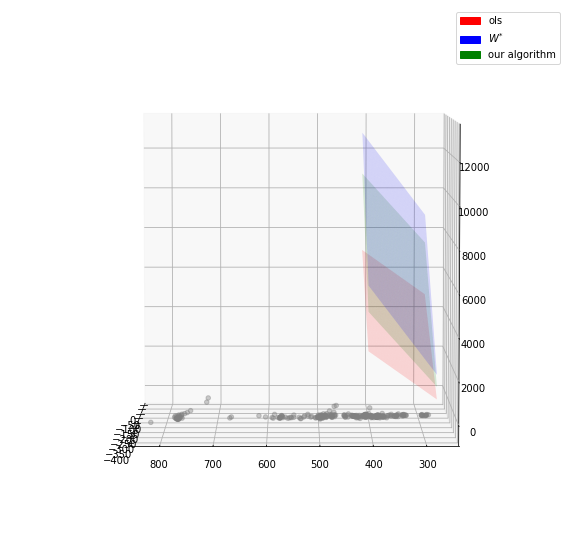

In [158]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0]/2, 1.0)
Y = np.arange(x_min[1], x_max[1]/2, 1.0)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = w_.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + w0_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(5.0, 180)

In [159]:
(Tensor(gt_ols.coef_) - w_.T).abs().sum()

tensor(7.1051)

In [160]:
np.abs(trunc_ols.coef_ - gt_ols.coef_).sum()

9.619945

In [161]:
trunc_ols.coef_

array([[  0.03977319,   1.6586212 , -10.473365  ,   5.5472813 ,
         -1.362283  ,   0.45242602,  -0.01257995,  -0.67500263,
         -0.0237042 ,  -0.6326117 ]], dtype=float32)

In [162]:
gt_ols.intercept_

array([35.22532], dtype=float32)

In [163]:
w0_

tensor([[26.8330]])

In [164]:
trunc_ols.intercept_

array([29.663986], dtype=float32)

In [165]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(17), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

In [166]:
(trunc_reg_params[:-1] - Tensor(gt_ols.coef_)).abs().sum()

tensor(7.1408)

In [167]:
gt_ols.coef_

array([[ 4.1732367e-02,  2.8715198e+00, -1.6511484e+01,  3.8322721e+00,
        -1.4202756e+00,  2.3889929e-01, -1.1430293e-02, -9.3549943e-01,
         1.0320530e-02, -5.4784405e-01]], dtype=float32)

In [168]:
trunc_ols.coef_

array([[  0.03977319,   1.6586212 , -10.473365  ,   5.5472813 ,
         -1.362283  ,   0.45242602,  -0.01257995,  -0.67500263,
         -0.0237042 ,  -0.6326117 ]], dtype=float32)

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [123]:
args = Parameters({
    "bias": True,
    "bs": 10,
    "trials": 100,
    "steps": 1000,
    "out_dir": '/Users/patroklos/regression', 
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
})
EXP = 'AirQuality'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [176]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

# Run Procedure

In [206]:
gt_var

tensor([8.9128])

In [191]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ozone, wind)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ozone) - wind.numpy(), 0))

C = [1.0, 2, 2.5, 3, 3.5, 4, 5, 6, 6.5, 7.0, 8.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(wind).eq(1).flatten()
        x_trunc, y_trunc = ozone[indices], wind[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / ozone.size(0)])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("ols params: ", ols_params)
        print("gt params: ", gt_params)
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(wind.flatten(), ols.predict(ozone).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /home/gridsan/stefanou/Regression/AirQuality/9db3846d-1128-4c80-b488-05bd4c3eb5ba
alpha:  tensor([1.])
ols params:  tensor([-0.0652, 12.7039])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.09644844383001328]
Iteration: 1.0 | Score: [0.11379536986351013]
Iteration: 2.0 | Score: [0.09146584570407867]
Iteration: 3.0 | Score: [0.04895583540201187]
Iteration: 4.0 | Score: [0.0071210190653800964]
Iteration: 0.0 | Score: [-0.18954379856586456, 0.6790188550949097]
Iteration: 1.0 | Score: [0.15723848342895508, -0.5712143182754517]
Iteration: 2.0 | Score: [-0.22678431868553162, 0.8314092755317688]
Iteration: 3.0 | Score: [-0.5465685129165649, 1.8951863050460815]
Iteration: 4.0 | Score: [0.2693268358707428, -1.0397220849990845]
Iteration: 5.0 | Score: [-0.08975881338119507, 0.34040749073028564]
Iteration: 6.0 | Score: [-0.19855782389640808, 0.6803900599479675]
Iteration: 7.0 | Score: [-0.14345692098140717, 0.5043009519577026]
Iteration: 8.0 | Score: [-0.077626794

Iteration: 2.0 | Score: [0.33660927414894104, -1.1059517860412598]
Iteration: 3.0 | Score: [-0.1548558473587036, 0.737293541431427]
Iteration: 4.0 | Score: [-0.0008948851027525961, 0.17620481550693512]
Iteration: 5.0 | Score: [0.01255469024181366, 0.12496758252382278]
Iteration: 6.0 | Score: [0.5440989136695862, -1.9664125442504883]
Iteration: 7.0 | Score: [0.4126148819923401, -1.4374372959136963]
Iteration: 8.0 | Score: [0.19856731593608856, -0.564809262752533]
Iteration: 9.0 | Score: [0.3306387960910797, -1.1038143634796143]
Iteration: 10.0 | Score: [0.07363545894622803, -0.13026419281959534]
Iteration: 0.0 | Score: [0.27475398778915405, -1.0851409435272217]
Iteration: 1.0 | Score: [0.13992717862129211, -0.5825761556625366]
Iteration: 2.0 | Score: [0.6193742156028748, -2.443345546722412]
Iteration: 3.0 | Score: [-0.02742133103311062, -0.016316860914230347]
Iteration: 4.0 | Score: [0.26869598031044006, -1.1151485443115234]
Iteration: 5.0 | Score: [0.3840940594673157, -1.57253813743591

Iteration: 5.0 | Score: [0.4646943211555481, -1.8291903734207153]
Iteration: 6.0 | Score: [0.4730321168899536, -1.8756872415542603]
Iteration: 7.0 | Score: [0.3135768473148346, -1.2362128496170044]
Iteration: 8.0 | Score: [0.8106727600097656, -3.3004698753356934]
Iteration: 9.0 | Score: [0.24558277428150177, -0.9833738803863525]
Iteration: 10.0 | Score: [0.9717714786529541, -4.039463043212891]
Iteration: 0.0 | Score: [0.2988484799861908, -1.1245543956756592]
Iteration: 1.0 | Score: [0.07745835185050964, -0.2495671510696411]
Iteration: 2.0 | Score: [-0.15322889387607574, 0.6620206832885742]
Iteration: 3.0 | Score: [0.5102236270904541, -2.02639102935791]
Iteration: 4.0 | Score: [0.9766778349876404, -4.213742733001709]
Iteration: 5.0 | Score: [0.007174776401370764, -0.009682059288024902]
alpha:  tensor([0.8954])
ols params:  tensor([-0.0508, 12.4823])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.16942664980888367]
Iteration: 1.0 | Score: [0.010658908635377884]
Itera

Iteration: 9.0 | Score: [0.07291340827941895, -0.3887290954589844]
Iteration: 10.0 | Score: [0.15900319814682007, -0.7718372941017151]
Iteration: 0.0 | Score: [0.47714194655418396, -2.278228521347046]
Iteration: 1.0 | Score: [1.153502345085144, -5.792402267456055]
Iteration: 2.0 | Score: [0.03515354543924332, -0.303246408700943]
Iteration: 3.0 | Score: [0.8039630055427551, -3.879667043685913]
Iteration: 4.0 | Score: [0.1420820951461792, -0.7858402729034424]
Iteration: 5.0 | Score: [0.26416417956352234, -1.3398635387420654]
Iteration: 6.0 | Score: [0.6211330890655518, -3.0752830505371094]
Iteration: 7.0 | Score: [0.050369326025247574, -0.4262453317642212]
Iteration: 8.0 | Score: [1.2606319189071655, -6.439657211303711]
Iteration: 9.0 | Score: [0.0353107750415802, -0.39871203899383545]
Iteration: 10.0 | Score: [0.3273734748363495, -1.698574185371399]
alpha:  tensor([0.6471])
ols params:  tensor([-0.0287, 12.8165])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.056011

Iteration: 9.0 | Score: [0.07509661465883255, -0.5197127461433411]
Iteration: 10.0 | Score: [0.28773462772369385, -1.4082082509994507]
Iteration: 0.0 | Score: [0.10522333532571793, -0.1752428412437439]
Iteration: 1.0 | Score: [-0.3264314532279968, 1.3203375339508057]
Iteration: 2.0 | Score: [-0.07241564244031906, 0.45527225732803345]
Iteration: 3.0 | Score: [0.476922869682312, -1.5777268409729004]
Iteration: 4.0 | Score: [0.7415906190872192, -2.6766510009765625]
Iteration: 5.0 | Score: [0.214742049574852, -0.5955715179443359]
Iteration: 6.0 | Score: [-0.09245432913303375, 0.4929364025592804]
Iteration: 7.0 | Score: [0.146145761013031, -0.3501329720020294]
Iteration: 8.0 | Score: [-0.285611093044281, 1.1273788213729858]
Iteration: 9.0 | Score: [-0.11512543261051178, 0.5783102512359619]
Iteration: 10.0 | Score: [0.2653828263282776, -0.8171193599700928]
alpha:  tensor([0.9869])
ols params:  tensor([-0.0634, 12.7028])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.4595

Iteration: 2.0 | Score: [-0.27384042739868164, 1.0958284139633179]
Iteration: 3.0 | Score: [0.5657801628112793, -2.0854618549346924]
Iteration: 4.0 | Score: [1.060267448425293, -4.319414138793945]
Iteration: 5.0 | Score: [0.5895907878875732, -2.258544445037842]
Iteration: 6.0 | Score: [0.0014954351354390383, 0.09465604275465012]
Iteration: 7.0 | Score: [0.22861815989017487, -0.75963294506073]
Iteration: 8.0 | Score: [-0.12726342678070068, 0.5347368717193604]
Iteration: 9.0 | Score: [-0.20697133243083954, 0.8449057340621948]
Iteration: 10.0 | Score: [0.21673233807086945, -0.7680527567863464]
Iteration: 0.0 | Score: [0.31841740012168884, -1.2106982469558716]
Iteration: 1.0 | Score: [0.2147253006696701, -0.7237493991851807]
Iteration: 2.0 | Score: [0.10293208062648773, -0.3162018954753876]
Iteration: 3.0 | Score: [1.3877564668655396, -5.987754821777344]
Iteration: 4.0 | Score: [0.0897204652428627, -0.2803143560886383]
Iteration: 5.0 | Score: [0.021271899342536926, -0.015469253063201904]
I

Iteration: 7.0 | Score: [-0.13055413961410522, 0.5088134407997131]
Iteration: 8.0 | Score: [-0.17788071930408478, 0.693107545375824]
Iteration: 9.0 | Score: [-0.197219118475914, 0.786125659942627]
Iteration: 10.0 | Score: [0.22852091491222382, -1.0125045776367188]
Iteration: 0.0 | Score: [0.7666804790496826, -2.8252274990081787]
Iteration: 1.0 | Score: [0.07885836809873581, -0.1686730682849884]
Iteration: 2.0 | Score: [0.5762961506843567, -2.036428451538086]
Iteration: 3.0 | Score: [0.5095050930976868, -1.7701834440231323]
Iteration: 4.0 | Score: [0.4614718556404114, -1.599128246307373]
Iteration: 5.0 | Score: [0.4683491587638855, -1.6293741464614868]
Iteration: 6.0 | Score: [1.3772670030593872, -5.675268173217773]
Iteration: 7.0 | Score: [0.46671420335769653, -1.6578503847122192]
Iteration: 8.0 | Score: [0.763719916343689, -2.8526406288146973]
Iteration: 9.0 | Score: [0.5359848141670227, -1.9079339504241943]
Iteration: 10.0 | Score: [0.6847978234291077, -2.5557610988616943]
alpha:  te

Iteration: 2.0 | Score: [1.4889674186706543, -7.603610038757324]
Iteration: 3.0 | Score: [0.06371485441923141, -0.2723468840122223]
Iteration: 4.0 | Score: [1.085697889328003, -5.378842353820801]
Iteration: 5.0 | Score: [0.5602835416793823, -2.6285650730133057]
Iteration: 6.0 | Score: [0.9216445684432983, -4.498005390167236]
Iteration: 7.0 | Score: [-0.0020255574490875006, -0.021338999271392822]
Iteration: 8.0 | Score: [0.32531023025512695, -1.5156763792037964]
Iteration: 9.0 | Score: [0.4957669973373413, -2.392885684967041]
Iteration: 10.0 | Score: [0.3574424684047699, -1.6899820566177368]
Logging in: /home/gridsan/stefanou/Regression/AirQuality/df290e52-c227-4e83-a100-17991f89a8cb
alpha:  tensor([1.])
ols params:  tensor([-0.0652, 12.7039])
gt params:  tensor([[-0.0652, 12.7039]])
Iteration: 0.0 | Score: [0.20089736580848694]
Iteration: 1.0 | Score: [0.09731356799602509]
Iteration: 2.0 | Score: [0.09249716997146606]
Iteration: 3.0 | Score: [0.005681954324245453]
Iteration: 0.0 | Scor

KeyboardInterrupt: 

# Results

In [182]:
store.close()

In [184]:
reader = CollectionReader(args.out_dir + EXP)
results = reader.df(TABLE_NAME)
results.head()

100%|██████████| 10/10 [00:00<00:00, 125.89it/s]


,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.277998,0.000010,0,0.034127,1.011202,0.276445,3,0.281893,0.000000,0.058253,1.000000,1.0,153,86c7b475-e4af-430d-9a87-3c3c058dc8cd
1,0.278144,0.026345,0,0.015193,0.969488,0.259547,2,0.281653,0.001476,0.337258,0.993464,2.0,152,86c7b475-e4af-430d-9a87-3c3c058dc8cd
2,0.276827,0.026245,0,0.314144,0.813266,0.263929,3,0.281247,0.000002,0.334309,0.986928,2.5,151,86c7b475-e4af-430d-9a87-3c3c058dc8cd
3,0.278337,0.010111,1,0.976901,0.982629,0.224470,4,0.280248,0.000297,0.466569,0.980392,3.0,150,86c7b475-e4af-430d-9a87-3c3c058dc8cd
4,0.278994,0.000388,0,0.009324,1.139410,0.231315,2,0.280879,0.000333,0.420097,0.973856,3.5,149,86c7b475-e4af-430d-9a87-3c3c058dc8cd


In [189]:
results.head(15)

,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,alpha,c,num_samples,exp_id
0,0.277998,0.000010,0,0.034127,1.011202,0.276445,3,0.281893,0.000000,0.058253,1.000000,1.0,153,86c7b475-e4af-430d-9a87-3c3c058dc8cd
1,0.278144,0.026345,0,0.015193,0.969488,0.259547,2,0.281653,0.001476,0.337258,0.993464,2.0,152,86c7b475-e4af-430d-9a87-3c3c058dc8cd
2,0.276827,0.026245,0,0.314144,0.813266,0.263929,3,0.281247,0.000002,0.334309,0.986928,2.5,151,86c7b475-e4af-430d-9a87-3c3c058dc8cd
3,0.278337,0.010111,1,0.976901,0.982629,0.224470,4,0.280248,0.000297,0.466569,0.980392,3.0,150,86c7b475-e4af-430d-9a87-3c3c058dc8cd
4,0.278994,0.000388,0,0.009324,1.139410,0.231315,2,0.280879,0.000333,0.420097,0.973856,3.5,149,86c7b475-e4af-430d-9a87-3c3c058dc8cd
5,0.264723,0.023325,0,0.000478,0.750131,0.222308,0,0.280490,0.000005,0.369918,0.967320,4.0,148,86c7b475-e4af-430d-9a87-3c3c058dc8cd
6,0.254123,0.089080,0,1.332225,0.517681,0.200302,2,0.273976,0.002056,0.576487,0.934641,5.0,143,86c7b475-e4af-430d-9a87-3c3c058dc8cd
7,0.250348,0.011384,0,0.059343,0.535562,0.278821,2,0.256005,0.024653,0.611852,0.895425,6.0,137,86c7b475-e4af-430d-9a87-3c3c058dc8cd
8,0.274417,0.144540,0,0.000659,1.632280,0.198839,2,0.217977,0.045553,0.812873,0.843137,6.5,129,86c7b475-e4af-430d-9a87-3c3c058dc8cd
9,0.279306,0.020996,0,0.128093,1.627416,0.258521,2,0.180237,0.002890,1.341405,0.784314,7.0,120,86c7b475-e4af-430d-9a87-3c3c058dc8cd


# Plot Results

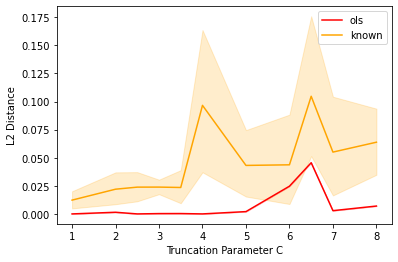

In [203]:
# plot results for regression parameter MSE
# sns.lineplot(data=results, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results, x='c', y='ols_param_mse', label='ols', color='red')
ax = sns.lineplot(data=results, x='c', y='known_param_mse', label='known', color='orange')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()

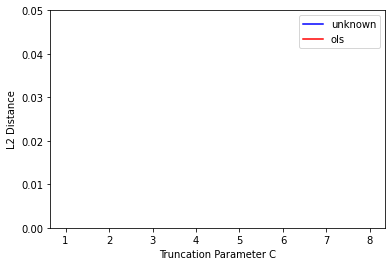

In [187]:
# plot results for regression noise variance MSE
sns.lineplot(data=results, x='c', y='unknown_var_l1', label='unknown', color="blue")
ax = sns.lineplot(data=results, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
ax.set(ylim=(0, .05))
plt.show()

In [ ]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(ozone, wind)
gt_params = Tensor(np.concatenate([gt.coef_, np.expand_dims(gt.intercept_, 0)], axis=1))
gt_var = Tensor(np.var(gt.predict(ozone) - wind.numpy(), 0))

C = [1.0, 2, 2.5, 3, 3.5, 4, 5, 6, 6.5, 7.0, 8.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
#         'trunc_reg_param_mse': float, 
#         'trunc_var_l1': float,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(wind).eq(1).flatten()
        x_trunc, y_trunc = ozone[indices], wind[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / ozone.size(0)])
        print("alpha: ", alpha)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        
        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(wind.flatten(), ols.predict(ozone).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params.flatten()),
        })
        
        val = int(.1*x_trunc.size(0))
        
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
        x_trunc_norm = x_trunc / beta
        
        # scale by the known noise variance 
        y_trunc_scaled = y_trunc / ch.sqrt(gt_var)
        phi_scaled = oracle.Left(phi.left / ch.sqrt(gt_var))
        
        # standardize noised by actual noise variance
        known_kwargs = { 
            'phi': phi_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with known noise variance using empirical noise variance
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, y_trunc_scaled) 
        
        with ch.no_grad():       
            w, w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) 
            known_params = ch.cat([w.flatten(), w0])
            # known results
            store[TABLE_NAME].update_row({
                'known_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'known_param_mse': mse_loss(known_params, gt_params.flatten()),
                'known_time': total_time, 
            })
            
        
        phi_emp_scaled = oracle.Left(phi.left / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = y_trunc / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled)  
        
        with ch.no_grad():      
            w, w0 = (unknown_trunc_reg.weight * unknown_trunc_reg.variance * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) * unknown_trunc_reg.variance 
            unknown_params = ch.cat([w, w0]).flatten()
            # known results
            store[TABLE_NAME].update_row({
                'unknown_r2': r2_score(wind.flatten(), ozone@w + w0), 
                'unknown_param_mse': mse_loss(unknown_params, gt_params.flatten()),
                'unknown_time': total_time, 
                'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var)
            })
            

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()